# Lunar albedo prediction using chemical data and neural network

First, import libraries:

In [3]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__) # print tensorflow version

2.8.0


Next, data is read in from csv datasets using Pandas. The values are reshaped into a list, making it easier to process.

In [4]:
# obtain iron data

fe = pd.read_csv("LPFe_Map.csv",header=None)
fe_train = fe.iloc[:,:360].values.flatten() # list of left values
fe_test = fe.iloc[:,360:].values.flatten() # list of right values

# obtain potassium data

k = pd.read_csv("LPK_Map.csv",header=None)
k_train = k.iloc[:,:360].values.flatten() # list of left values
k_test = k.iloc[:,360:].values.flatten() # list of right values

# obtain titanium data

ti = pd.read_csv("LPTi_Map.csv",header=None)
ti_train = ti.iloc[:,:360].values.flatten() # list of left values
ti_test = ti.iloc[:,360:].values.flatten() # list of right values

# obtain thorium data

th = pd.read_csv("LPTh_Map.csv",header=None)
th_train = th.iloc[:,:360].values.flatten() # list of left values
th_test = th.iloc[:,360:].values.flatten() # list of right values

# obtain albedo data

albedo = pd.read_csv("Moon_Albedo_Map.csv",header=None)
al_train = albedo.iloc[:,:360].values.flatten() # list of left values
al_test = albedo.iloc[:,360:].values.flatten() # list of right values

The neural network accepts four inputs (element concentrations). These inputs are each passed through a normalization layer to change them into a value from 0-1 for processing in the model.

In [5]:
# define inputs and normalization layers

ip_fe = keras.Input(shape=(1,))
norm_fe = layers.Normalization(input_shape=(1,),axis=None)(ip_fe)

ip_k = keras.Input(shape=(1,))
norm_k = layers.Normalization(input_shape=(1,),axis=None)(ip_k)

ip_ti = keras.Input(shape=(1,))
norm_ti = layers.Normalization(input_shape=(1,),axis=None)(ip_ti)

ip_th = keras.Input(shape=(1,))
norm_th = layers.Normalization(input_shape=(1,),axis=None)(ip_th)

Next, the neural network is constructed. In order to pass through the following layers of the neural network, the normalized input arrays must be concatenated together into one object. This object is then passed through 3 dense layers. The regression model is non-linear, as the relationship between element concentrations and albedo was determined to be non-linear from plotting individual graphs for each. 

In [6]:
# build neural network

concat = layers.Concatenate()([norm_fe,norm_k,norm_ti,norm_th])
dense1 = layers.Dense(64,activation="relu")(concat) # 64 nodes, "relu" means nonlinear model used
dense2 = layers.Dense(64,activation="relu")(dense1) # "
output = layers.Dense(1)(dense2)

model = keras.Model(inputs=[ip_fe,ip_k,ip_ti,ip_th],outputs=output) # creates model

# compile and summary

model.compile(loss="mean_absolute_error",optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

Now that the model has been built, it can be fitted to all of the training data (the left side of the maps) to determine errors.

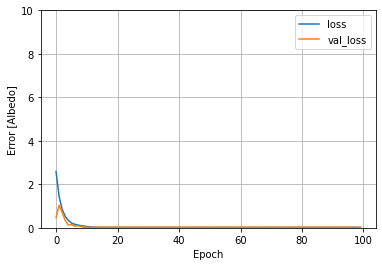

In [7]:
# write history

history = model.fit(x=[fe_train,k_train,ti_train,th_train],y=al_train,validation_split=0.2,verbose=0,epochs=100)

# plot error vs epoch

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Albedo]')
  plt.legend()
  plt.grid(True)

plot_loss(history)
plt.show()

Finally, the albedo of the right side of the lunar map is predicted and plotted as a contourmap. This allows for comparison with the actual test values (right side) of the albedo data. The y-axis is inverted so that the origin (0,0) is located in the upper left corner, as represented in the dataset.

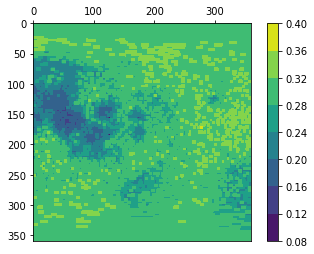

In [13]:
# predict albedo using test data

predicted_albedo = model.predict([fe_test,k_test,ti_test,th_test]).flatten()
predicted_albedo = predicted_albedo.reshape(360,360)

# plot predicted albedo

fig, ax = plt.subplots()

xvals = np.arange(0,360,1)
yvals = np.arange(0,360,1)

# flip graph

ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_aspect(1)
g = ax.contourf(xvals,yvals,predicted_albedo)
plt.colorbar(g)
plt.show()

Finally, the error is plotted to see how accurate the prediction is to the real right-hand-side of the moon.

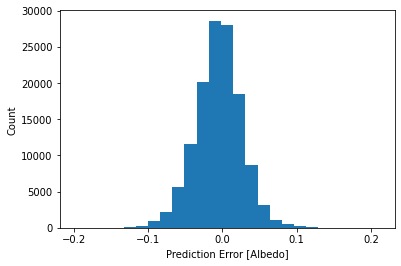

In [12]:
predicted_albedo = predicted_albedo.reshape(129600,)
error = predicted_albedo - al_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Albedo]')
_ = plt.ylabel('Count')

The error forms a sharp peak at 0, showing that very few predicted datapoints have significant error (up to +- 0.1). This shows that the model is a good fit.